## **Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, classification_report, accuracy_score

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')


## **Load data**

In [2]:
titanic = pd.read_csv('titanic2.csv')
titanic

,sex,age,parch,fare,class,deck,embark_town,alive,alone
0,male,22.0,0,7.2500,Third,NaN,Southampton,no,False
1,female,38.0,0,71.2833,First,C,Cherbourg,yes,False
2,female,26.0,0,7.9250,Third,NaN,Southampton,yes,True
3,female,35.0,0,53.1000,First,C,Southampton,yes,False
4,male,35.0,0,8.0500,Third,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...
886,male,27.0,0,13.0000,Second,NaN,Southampton,no,True
887,female,19.0,0,30.0000,First,B,Southampton,yes,True
888,female,NaN,2,23.4500,Third,NaN,Southampton,no,False
889,male,26.0,0,30.0000,First,C,Cherbourg,yes,True


In [3]:
titanic['alive'].value_counts()

no     549
yes    342
Name: alive, dtype: int64

In [4]:
titanic.shape

(891, 9)

In [5]:
# Identify a single value in columns
titanic.nunique()

sex              2
age             88
parch            7
fare           248
class            3
deck             7
embark_town      3
alive            2
alone            2
dtype: int64

In [6]:
titanic.describe(include=object)

,sex,class,deck,embark_town,alive
count,891,891,203,889,891
unique,2,3,7,3,2
top,male,Third,C,Southampton,no
freq,577,491,59,644,549


In [7]:
titanic['alive'].value_counts()

no     549
yes    342
Name: alive, dtype: int64

In [8]:
# if there is any missing values
titanic.isnull().sum()

sex              0
age            177
parch            0
fare             0
class            0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Age, deck, and embark_town have missing values. For age and embark_town, the missing values ​​will be filled in using a simple imputer, while the feature deck will be dropped later.

## **EDA**

### **Sex**

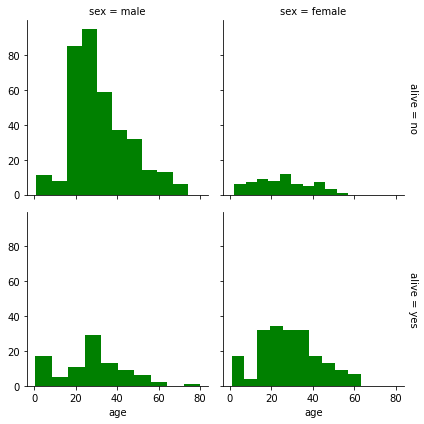

In [9]:
sex_alive = sns.FacetGrid(titanic, col='sex', row='alive', margin_titles=True)
sex_alive.map(plt.hist, 'age', color= 'green')
plt.show()

Based on gender, the number of alive in females is significantly higher than males, with the highest age distribution ranging from 18 to 38.

### **Age**

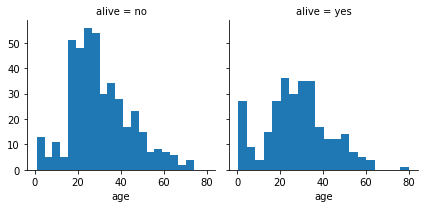

In [10]:
age_alive = sns.FacetGrid(titanic, col='alive')
age_alive.map(plt.hist, 'age', bins=20)
plt.show()

### **Class and Fare**

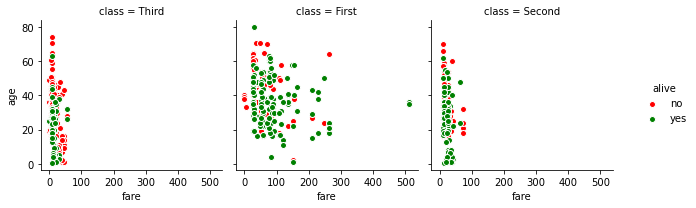

In [11]:
class_fare = sns.FacetGrid(titanic, hue='alive', col='class', margin_titles=True, palette={'yes':'green', 'no':'red'})
class_fare.map(plt.scatter, 'fare', 'age', edgecolor='w').add_legend()
plt.show()

In [12]:
titanic.groupby('class')['alive'].value_counts()

class   alive
First   yes      136
        no        80
Second  no        97
        yes       87
Third   no       372
        yes      119
Name: alive, dtype: int64

In [13]:
titanic.groupby('class')['alive'].value_counts()/titanic.shape[0]*100

class   alive
First   yes      15.263749
        no        8.978676
Second  no       10.886644
        yes       9.764310
Third   no       41.750842
        yes      13.355780
Name: alive, dtype: float64

- The highest number of passengers came from the Third class.
- The highest number of surviving passengers came from First class (15%), followed by Third class (13%).

### **Age, Gender, Fare**

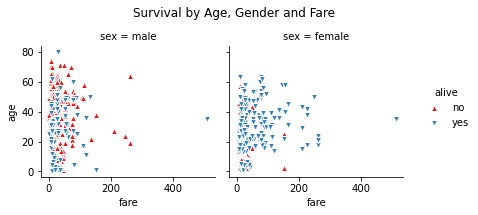

In [14]:
age_gender_fare = sns.FacetGrid(titanic, hue='alive', col='sex', margin_titles=True, palette='Set1', hue_kws=dict(marker=['^', 'v']))
age_gender_fare.map(plt.scatter, 'fare', 'age',edgecolor='w').add_legend()
plt.subplots_adjust(top=0.8)
age_gender_fare.fig.suptitle('Survival by Age, Gender and Fare')
plt.show()

In [15]:
titanic.groupby('sex')['alive'].value_counts()

sex     alive
female  yes      233
        no        81
male    no       468
        yes      109
Name: alive, dtype: int64

In [16]:
titanic.groupby('sex')['alive'].value_counts()/titanic.shape[0]*100

sex     alive
female  yes      26.150393
        no        9.090909
male    no       52.525253
        yes      12.233446
Name: alive, dtype: float64

- The number of female passengers who survived exceeded 2 times the number of male passengers who survived.
- More than 50% of the total passengers who did not survive were male.

### **Embark Town**

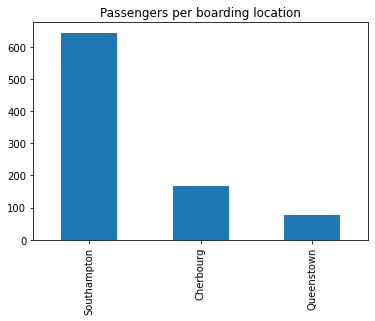

In [17]:
titanic.embark_town.value_counts().plot(kind='bar')
plt.title('Passengers per boarding location')
plt.show()

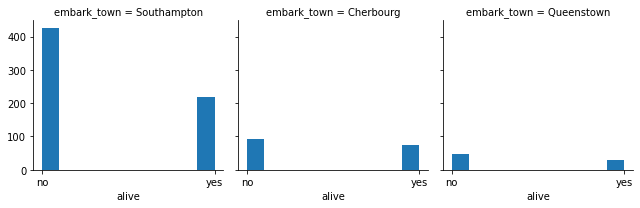

In [18]:
embark_alive = sns.FacetGrid(titanic, col='embark_town')
embark_alive.map(plt.hist, 'alive')
plt.show()

In [19]:
titanic.groupby('embark_town')['alive'].value_counts()

embark_town  alive
Cherbourg    yes       93
             no        75
Queenstown   no        47
             yes       30
Southampton  no       427
             yes      217
Name: alive, dtype: int64

In [20]:
titanic.groupby('embark_town')['alive'].value_counts()/titanic.shape[0]*100

embark_town  alive
Cherbourg    yes      10.437710
             no        8.417508
Queenstown   no        5.274972
             yes       3.367003
Southampton  no       47.923681
             yes      24.354658
Name: alive, dtype: float64

### **Embark Town and Class**

In [21]:
titanic.groupby('embark_town')['class'].value_counts()

embark_town  class 
Cherbourg    First      85
             Third      66
             Second     17
Queenstown   Third      72
             Second      3
             First       2
Southampton  Third     353
             Second    164
             First     127
Name: class, dtype: int64

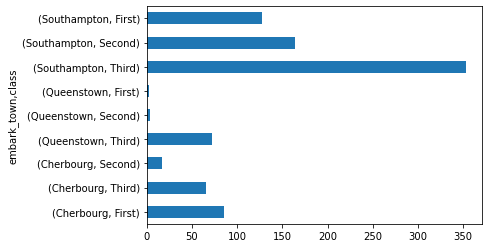

In [22]:
titanic.groupby('embark_town')['class'].value_counts().plot(kind='barh');

- Based on the origin of departure, passengers departing from Southampton are the most.
- However, when viewed from the point of departure, only Cherbourg has a higher ratio of the number of survivors. This may be due to the fact that passengers from Cherbourg were First class passengers, which probably took precedence when disaster struck.

### **Alone**

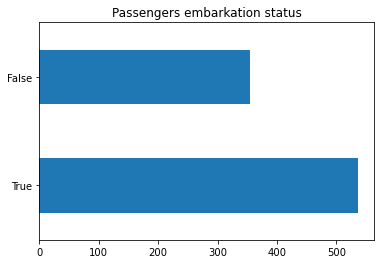

In [23]:
titanic.alone.value_counts().plot(kind='barh')
plt.title('Passengers embarkation status')
plt.show()

In [24]:
titanic.groupby('alone')['alive'].value_counts()

alone  alive
False  yes      179
       no       175
True   no       374
       yes      163
Name: alive, dtype: int64

In [25]:
titanic.groupby('alone')['class'].value_counts()

alone  class 
False  Third     167
       First     107
       Second     80
True   Third     324
       First     109
       Second    104
Name: class, dtype: int64

Passengers traveling alone are more likely to be unsafe. Most passengers departing alone are Third class passengers.

## **Preprocessing scheme**

In [26]:
ordinal_mapping= [
    {'col':'class',
    'mapping': {None:0, 'First':1, 'Second':2, 'Third':3}}]
ordinal_encoder = ce.OrdinalEncoder(cols = 'class', mapping=ordinal_mapping)

In [27]:
binary_encoder_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('binary encoder', ce.BinaryEncoder())
])

transformer = ColumnTransformer([
    ('one hot encoder', OneHotEncoder(drop='first'), ['sex', 'alone']),
    ('ordinal encoding', ordinal_encoder, ['class']),
    ('simple imputer', SimpleImputer(strategy='median'), ['age']),
    ('binary encoder', binary_encoder_pipeline, ['embark_town'])
], remainder='passthrough')

## **Data Splitting**

In [28]:
X = titanic.drop(columns = ['alive', 'deck'])
y = np.where(titanic['alive'] == 'yes', 1, 0)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.2,
    stratify = y,
    random_state = 0)

## **Data Transformation**

In [30]:
X_train_prep = transformer.fit_transform(X_train)
X_test_prep = transformer.transform(X_test)

In [31]:
X_train_prep = pd.DataFrame(X_train_prep)
X_test_prep = pd.DataFrame(X_test_prep)

In [32]:
transformer.transformers_

[('one hot encoder', OneHotEncoder(drop='first'), ['sex', 'alone']),
 ('ordinal encoding',
  OrdinalEncoder(cols=['class'],
                 mapping=[{'col': 'class',
                           'mapping': {None: 0, 'First': 1, 'Second': 2,
                                       'Third': 3}}]),
  ['class']),
 ('simple imputer', SimpleImputer(strategy='median'), ['age']),
 ('binary encoder',
  Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                  ('binary encoder', BinaryEncoder())]),
  ['embark_town']),
 ('remainder', 'passthrough', [2, 3])]

In [33]:
transformer.transformers_[0][1].get_feature_names()

array(['x0_male', 'x1_True'], dtype=object)

In [34]:
transformer.transformers_[1][1].get_feature_names()

['class']

In [35]:
transformer.transformers_[3][1][1].get_feature_names()

['0_0', '0_1']

In [36]:
features = list(transformer. transformers_[0][1].get_feature_names()) + transformer.transformers_[1][1].get_feature_names() + ['age'] + transformer.transformers_[3][1][1].get_feature_names() + ['parch', 'fare']
X_train_prep.columns = features
X_test_prep.columns = features
X_train_prep

,x0_male,x1_True,class,age,0_0,0_1,parch,fare
0,0.0,1.0,3.0,28.0,0.0,1.0,0.0,7.6292
1,1.0,1.0,3.0,28.0,1.0,0.0,0.0,8.0500
2,0.0,1.0,3.0,28.0,0.0,1.0,0.0,7.7500
3,0.0,0.0,1.0,51.0,1.0,0.0,0.0,77.9583
4,1.0,1.0,3.0,21.0,0.0,1.0,0.0,7.7333
...,...,...,...,...,...,...,...,...
707,1.0,1.0,3.0,20.0,1.0,0.0,0.0,7.0500
708,1.0,0.0,3.0,28.0,1.0,0.0,0.0,19.9667
709,1.0,1.0,3.0,39.0,1.0,0.0,0.0,7.9250
710,1.0,0.0,3.0,28.0,1.0,1.0,0.0,21.6792


In [37]:
X_test_prep

,x0_male,x1_True,class,age,0_0,0_1,parch,fare
0,1.0,0.0,3.0,40.5,1.0,0.0,2.0,14.5000
1,1.0,1.0,3.0,33.0,1.0,0.0,0.0,9.5000
2,0.0,0.0,3.0,39.0,1.0,0.0,5.0,31.2750
3,1.0,1.0,3.0,28.0,1.0,0.0,0.0,9.5000
4,0.0,1.0,1.0,24.0,1.0,1.0,0.0,83.1583
...,...,...,...,...,...,...,...,...
174,1.0,1.0,1.0,71.0,1.0,1.0,0.0,34.6542
175,0.0,0.0,2.0,45.0,1.0,0.0,1.0,26.2500
176,1.0,1.0,3.0,25.0,1.0,0.0,0.0,7.6500
177,1.0,1.0,3.0,19.0,1.0,0.0,0.0,14.5000


In [38]:
# Check missing values
X_train_prep.isna().sum()

x0_male    0
x1_True    0
class      0
age        0
0_0        0
0_1        0
parch      0
fare       0
dtype: int64

In [39]:
X_test_prep.isna().sum()

x0_male    0
x1_True    0
class      0
age        0
0_0        0
0_1        0
parch      0
fare       0
dtype: int64

## **Model Performance**

In [40]:
# Define models
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)
logreg = LogisticRegression(random_state=0)
rf = RandomForestClassifier(random_state=0)

# Define imbalance treatment methods
models = [knn, tree, logreg, rf]
score = []
nilai_mean = []
nilai_std = []

for i in models:
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    estimator = Pipeline([
        ('preprocessing', transformer),
        ('model', i)
    ])

    model_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='f1', error_score='raise')
    score.append(model_cv)
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [41]:
pd.DataFrame({
    'model':['knn', 'tree', 'logreg', 'rf'],
    'mean':nilai_mean,
    'std':nilai_std
})

,model,mean,std
0,knn,0.568421,0.055999
1,tree,0.722360,0.037634
2,logreg,0.717794,0.041955
3,rf,0.740193,0.035176


From the results above, it can be seen that the random forest model has the best and most stable performance when viewed from the average F1 score and standard deviation. As for the logistic regression and decision tree, the results are only slightly different, but the logistic regression is slightly better.

## **Model Performance on Test Set**

In [42]:
models={
    'Logistic Regression': LogisticRegression(random_state=0),
    'Random Forest': RandomForestClassifier(random_state=0),  
}

score=[]

for i in models:
    models[i].fit(X_train_prep, y_train)
    y_pred=models[i].predict(X_test_prep)
    score.append([f1_score(y_test, y_pred)])

score_before_tuning = pd.DataFrame(score, columns=['F1 score'], index = models.keys())
score_before_tuning


,F1 score
Logistic Regression,0.703125
Random Forest,0.704000


## **Hyperparamater Tuning**

In [43]:
# Logistic Regression
hyperparam_space_logreg = {
    'C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'max_iter': [100, 200, 300, 400, 500, 1000]

}

# Random forest

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

hyperparam_space_rf = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [44]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

logreg = LogisticRegression(random_state=0)
rf = RandomForestClassifier(random_state=0)

random_logreg = RandomizedSearchCV(
    logreg,
    param_distributions = hyperparam_space_logreg,
    cv = skfold,
    scoring= 'f1',
    n_jobs= -1
)

random_rf = RandomizedSearchCV(
    rf, 
    param_distributions = hyperparam_space_rf,
    cv = skfold,
    scoring= 'f1',
    n_jobs= -1
)

In [45]:
random_logreg.fit(X_train_prep, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=LogisticRegression(random_state=0), n_jobs=-1,
                   param_distributions={'C': [1000, 500, 100, 50, 10, 5, 1, 0.5,
                                              0.1, 0.05, 0.01, 0.005, 0.001,
                                              0.0005, 0.0001],
                                        'max_iter': [100, 200, 300, 400, 500,
                                                     1000],
                                        'solver': ['liblinear', 'newton-cg',
                                                   'lbfgs']},
                   scoring='f1')

In [46]:
random_rf.fit(X_train_prep, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
                   estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='f1')

In [47]:
print('Best score logreg:', random_logreg.best_score_)
print('Best params logreg:', random_logreg.best_params_)
print('Best score rf:', random_rf.best_score_)
print('Best params rf:', random_rf.best_params_)

Best score logreg: 0.7356436826369317
Best params logreg: {'solver': 'liblinear', 'max_iter': 200, 'C': 500}
Best score rf: 0.7806417677677725
Best params rf: {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}


## **Model Performance After Tuning**

In [48]:
logreg_tuning = random_logreg.best_estimator_
logreg_tuning.fit(X_train_prep, y_train)

rf_tuning = random_rf.best_estimator_
rf_tuning.fit(X_train_prep, y_train)

y_pred_logreg_tuning = logreg_tuning.predict(X_test_prep)
y_pred_rf_tuning = rf_tuning.predict(X_test_prep)

f1_logreg_tuning = f1_score(y_test, y_pred_logreg_tuning)
f1_rf_tuning = f1_score(y_test, y_pred_rf_tuning)

In [49]:
score_list = [f1_logreg_tuning, f1_rf_tuning]
models = ['Logistic Regression', 'Random Forest']
score_after_tuning = pd.DataFrame({
    'Model': models,
    'F1 score': score_list
})

## **Comparison of f1_score**

In [50]:
score_before_tuning

,F1 score
Logistic Regression,0.703125
Random Forest,0.704000


In [51]:
score_after_tuning

,Model,F1 score
0,Logistic Regression,0.703125
1,Random Forest,0.728682


## **Summary**

1. The best model to predict whether someone will survive or not on the titanic dataset based on the f1_score is Random Forest with hyperparameter tuning.
2. The hyperparamater tuning process makes the f1_score in the random forest model increase by about 0.04, from 0.68 to 0.72. It is different with the logistic regression model which does not change at all in its f1_score.